# TACO Inspection Demo

This notebook contains several independent scripts that show how to load and visualize the dataset stats and annotated images:
- Section 1 shows the dataset stats
- Section 2 show the class hierarchical structure: super classes and classes
- Section 3 shows TACO images along with their segmentation masks

But first we need to load the annotations and some python libraries:

In [6]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [7]:
# Same but for the custom dataset for the ARC project
dataset_path = './segments/festay_arc_litter/v2.1'
anns_file_path = './segments/festay_arc_litter/arc_litter-v2.1_coco.json'


# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 0
Number of categories: 2
Number of annotations: 793
Number of images: 43


## 1.  Dataset statistics

This shows the number of annotations per category:

In [36]:
cat_histogram

array([389, 404])

,Categories,Number of annotations
1,other litter,404
0,plastic litter,389


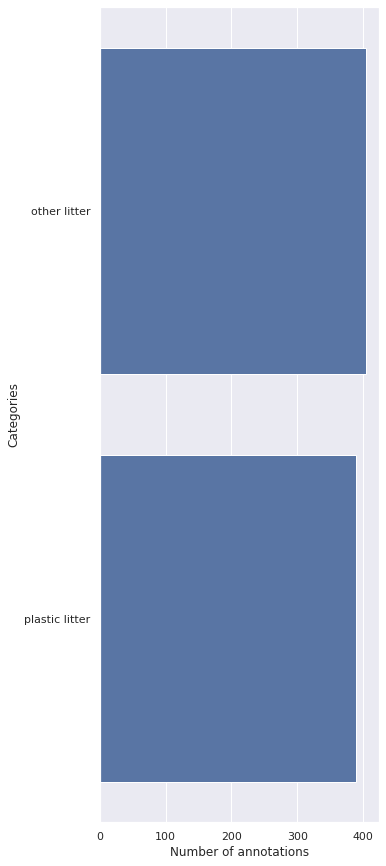

In [34]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,15))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b", orient="h" )

# fig = plot_1.get_figure()
# fig.savefig("output.png")



and this shows the number of annotations per super category:

In [12]:
cat_ids_2_supercat_ids = {}
for cat in categories:
    cat_ids_2_supercat_ids[cat['id']] = super_cat_ids[cat['supercategory']]

# Count annotations
super_cat_histogram = np.zeros(nr_super_cats,dtype=int)
for ann in anns:
    cat_id = ann['category_id']
    super_cat_histogram[cat_ids_2_supercat_ids[cat_id]] +=1
    
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,10))

# Convert to DataFrame
d ={'Super categories': super_cat_names, 'Number of annotations': super_cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values('Number of annotations', 0, False)

# sns.set_color_codes("pastel")
# sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Super categories", data=df,
            label="Total", color="b", orient=1)
#plot_1.set_title('Annotations per super category',fontsize=20)   

KeyError: 'supercategory'

### 1.1  Background stats

## 2. Visualize dataset graph

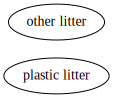

In [18]:
from graphviz import Digraph
# Note: graphviz may require more than pip installation due to path issue: e.g. brew install graphviz for mac

#g = Digraph('G', filename='hello.gv')
dot = Digraph('Dataset graph', filename='asd.gv')
dot.attr(rankdir='LR', size='8,10')

for cat_it in categories:
    dot.node(cat_it['name'])
    
dot
# Uncomment next line to print pdf
#dot.view()

## 3. Visualize Annotated Images

For simplicity, to select and show the dataset images with the respective masks, we make use of the COCO API.
The script below shows how to load and visualize an image with all its annotations.

Unfortunately, several python libraries do not take into account the EXIF orientation tag, thus we have to explicitly rotate the images. Alternatively you can use instead OpenCV.

In [19]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

# User settings
image_filepath = 'batch_11/000028.jpg'
pylab.rcParams['figure.figsize'] = (28,28)
####################

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Find image id
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break

# Show image and corresponding annotations
if img_id == -1:
    print('Incorrect file name')
else:

    # Load image
    print(image_filepath)
    I = Image.open(dataset_path + '/' + image_filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Incorrect file name


The script below shows how to filter images by either category or supercategory.

Go ahead and try different (super)categories searches by changing the `category_name`.
Note that small objects may be hard to see.

In [17]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

# User settings
nr_img_2_display = 10
category_name = 'Bottle'#  --- Insert the name of one of the categories or super-categories above
pylab.rcParams['figure.figsize'] = (14,14)
####################

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Get image ids
imgIds = []
catIds = coco.getCatIds(catNms=[category_name])
if catIds:
    # Get all images containing an instance of the chosen category
    imgIds = coco.getImgIds(catIds=catIds)
else:
    # Get all images containing an instance of the chosen super category
    catIds = coco.getCatIds(supNms=[category_name])
    for catId in catIds:
        imgIds += (coco.getImgIds(catIds=catId))
    imgIds = list(set(imgIds))

nr_images_found = len(imgIds) 
print('Number of images found: ',nr_images_found)

# Select N random images
random.shuffle(imgIds)
imgs = coco.loadImgs(imgIds[0:min(nr_img_2_display,nr_images_found)])

for img in imgs:
    image_path = dataset_path + '/' + img['file_name']
    # Load image
    I = Image.open(image_path)
    
    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)
    
    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns_sel = coco.loadAnns(annIds)
    
    # Show annotations
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


KeyError: 'supercategory'